In [400]:
# Importing libraries and API endpoints

import pandas as pd

from sklearn.preprocessing import LabelEncoder
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from sklearn.metrics import mean_squared_error
from scipy.stats import ks_2samp

from datetime import timedelta
from datetime import datetime
import matplotlib.pyplot as plt
import math

from nba_api.stats.endpoints import boxscoreplayertrackv2
from nba_api.stats.endpoints import boxscoreadvancedv2
from nba_api.stats.endpoints import boxscoreadvancedv3
from nba_api.stats.endpoints import boxscorescoringv2
from nba_api.stats.endpoints import teamgamelog
from nba_api.stats.endpoints import teamgamelogs
from nba_api.stats.static import teams
from nba_api.stats.endpoints import boxscorescoringv3
from nba_api.live.nba.endpoints import playbyplay
from sbrscrape import Scoreboard

# Extracting raw game data from NBA API

In [2]:
# Testing endpoint
# pd.DataFrame(teams.get_teams())
# boxscore = boxscoreadvancedv3.BoxScoreAdvancedV3().team_stats.get_data_frame()
# boxscore_df = pd.DataFrame(boxscore)
# boxscore_df.columns

# help(boxscoreadvancedv2)

Help on module nba_api.stats.endpoints.boxscoreadvancedv2 in nba_api.stats.endpoints:

NAME
    nba_api.stats.endpoints.boxscoreadvancedv2

CLASSES
    nba_api.stats.endpoints._base.Endpoint(builtins.object)
        BoxScoreAdvancedV2
    
    class BoxScoreAdvancedV2(nba_api.stats.endpoints._base.Endpoint)
     |  BoxScoreAdvancedV2(game_id, end_period='0', end_range='0', range_type='0', start_period='0', start_range='0', proxy=None, headers=None, timeout=30, get_request=True)
     |  
     |  Method resolution order:
     |      BoxScoreAdvancedV2
     |      nba_api.stats.endpoints._base.Endpoint
     |      builtins.object
     |  
     |  Methods defined here:
     |  
     |  __init__(self, game_id, end_period='0', end_range='0', range_type='0', start_period='0', start_range='0', proxy=None, headers=None, timeout=30, get_request=True)
     |      Initialize self.  See help(type(self)) for accurate signature.
     |  
     |  get_request(self)
     |  
     |  load_response(self)


In [291]:
gamelogs_df = teamgamelogs.TeamGameLogs(season_nullable='2024').team_game_logs.get_data_frame()

In [358]:
season_years = []
for year in range(2018, 2024):
    season_years.append(f"{year}-{str(year+1)[-2:]}")

gamelogs_data = []
gamelogs_df = pd.DataFrame()

for season in season_years:
    gamelogs = teamgamelogs.TeamGameLogs(season_nullable=season).team_game_logs.get_data_frame()
    gamelogs_data.append(gamelogs)

gamelogs_df = pd.concat(gamelogs_data)

In [363]:
# Sort sequentially by Game ID
gamelogs_df = gamelogs_df.sort_values(by='GAME_ID', ascending=True)
gamelogs_df.reset_index(drop=True, inplace=True)

In [364]:
gamelogs_df

,SEASON_YEAR,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS
0,2018-19,1610612755,PHI,Philadelphia 76ers,0021800001,2018-10-16T00:00:00,PHI @ BOS,L,48.0,34,...,41,47,18,16.0,8,5,5,20,20,87
1,2018-19,1610612738,BOS,Boston Celtics,0021800001,2018-10-16T00:00:00,BOS vs. PHI,W,48.0,42,...,43,55,21,15.0,7,5,5,20,20,105
2,2018-19,1610612760,OKC,Oklahoma City Thunder,0021800002,2018-10-16T00:00:00,OKC @ GSW,L,48.0,33,...,29,45,21,15.0,12,6,7,21,29,100
3,2018-19,1610612744,GSW,Golden State Warriors,0021800002,2018-10-16T00:00:00,GSW vs. OKC,W,48.0,42,...,41,58,28,21.0,7,7,6,29,21,108
4,2018-19,1610612749,MIL,Milwaukee Bucks,0021800003,2018-10-17T00:00:00,MIL @ CHA,W,48.0,42,...,46,57,26,21.0,5,4,9,25,19,113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13287,2023-24,1610612758,SAC,Sacramento Kings,0022301228,2023-12-08T00:00:00,SAC @ PHX,W,48.0,42,...,35,50,25,13.0,7,0,5,22,19,114
13288,2023-24,1610612754,IND,Indiana Pacers,0022301229,2023-12-07T00:00:00,IND @ MIL,W,48.0,50,...,36,51,30,10.0,9,8,9,21,17,128
13289,2023-24,1610612749,MIL,Milwaukee Bucks,0022301229,2023-12-07T00:00:00,MIL vs. IND,L,48.0,43,...,34,46,19,12.0,3,9,8,17,21,119
13290,2023-24,1610612747,LAL,Los Angeles Lakers,0022301230,2023-12-07T00:00:00,LAL vs. NOP,W,48.0,47,...,48,59,31,15.0,6,4,5,16,21,133


In [361]:
# Initial preprocessing
# Dropping all columns with suffix "_RANK" and other irrelevant columns (PLUS_MINUS is the point diff which we FE)
gamelogs_df = gamelogs_df.drop(columns=gamelogs_df.filter(regex='_RANK').columns)
gamelogs_df = gamelogs_df.drop(columns=['AVAILABLE_FLAG', 'PLUS_MINUS'])

In [362]:
from requests.exceptions import ReadTimeout

def retry_with_timeout(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        max_attempts = kwargs.pop('max_attempts', 3)
        delay = kwargs.pop('delay', 10)  # Sleep time between retries
        attempts = 0
        while attempts < max_attempts:
            try:
                return func(*args, **kwargs)
            except ReadTimeout as e:
                print(f"Timeout error occurred: {e}")
                attempts += 1
                time.sleep(delay)  # Sleep before retrying
        raise ReadTimeout(f"Function {func.__name__} failed after {max_attempts} attempts")

    return wrapper

boxscore = []
ids_not_retrieved = []

unique_game_ids = gamelogs_df['GAME_ID'].unique()

for id in unique_game_ids:
    try:
        boxscore_df = boxscoreadvancedv3.BoxScoreAdvancedV3(game_id=id).team_stats.get_data_frame()
        boxscore.append(boxscore_df)
        print(f"Retrieved {id}. Moving to the next game ID.")
    except ReadTimeout as e:
        ids_not_retrieved.append(id)
        print(f"Timeout error occurred for game ID: {id}. Moving to the next game ID.")

unique_game_ids = ids_not_retrieved

if boxscore:
    boxscore_df = pd.concat(boxscore, ignore_index=True)

boxscore_df

Retrieved 0021800001. Moving to the next game ID.
Retrieved 0021800002. Moving to the next game ID.
Retrieved 0021800003. Moving to the next game ID.
Retrieved 0021800004. Moving to the next game ID.
Retrieved 0021800005. Moving to the next game ID.
Retrieved 0021800006. Moving to the next game ID.
Retrieved 0021800007. Moving to the next game ID.
Retrieved 0021800008. Moving to the next game ID.
Retrieved 0021800009. Moving to the next game ID.
Retrieved 0021800010. Moving to the next game ID.
Retrieved 0021800011. Moving to the next game ID.
Retrieved 0021800012. Moving to the next game ID.
Retrieved 0021800013. Moving to the next game ID.
Retrieved 0021800014. Moving to the next game ID.
Retrieved 0021800015. Moving to the next game ID.
Retrieved 0021800016. Moving to the next game ID.
Retrieved 0021800017. Moving to the next game ID.
Retrieved 0021800018. Moving to the next game ID.
Retrieved 0021800019. Moving to the next game ID.
Retrieved 0021800020. Moving to the next game ID.


ConnectionError: ('Connection aborted.', ConnectionResetError(54, 'Connection reset by peer'))

In [365]:
boxscore_df

,gameId,teamId,teamCity,teamName,teamTricode,teamSlug,minutes,estimatedOffensiveRating,offensiveRating,estimatedDefensiveRating,...,turnoverRatio,effectiveFieldGoalPercentage,trueShootingPercentage,usagePercentage,estimatedUsagePercentage,estimatedPace,pace,pacePer40,possessions,PIE
0,0021801198,1610612765,Detroit,Pistons,DET,pistons,240:00,101.6,101.1,107.1,...,10.0,0.424,0.461,1.0,0.199,93.36,89.5,74.58,90.0,0.437
1,0021801198,1610612766,Charlotte,Hornets,CHA,hornets,240:00,107.1,116.9,101.6,...,7.9,0.489,0.530,1.0,0.194,93.36,89.5,74.58,89.0,0.563


In [52]:
boxscore_cols = ['gameId', 'teamId', 'estimatedOffensiveRating', 'offensiveRating',
       'estimatedDefensiveRating', 'defensiveRating', 'estimatedNetRating',
       'netRating', 'assistPercentage', 'assistToTurnover', 'assistRatio',
       'offensiveReboundPercentage', 'defensiveReboundPercentage',
       'reboundPercentage', 'estimatedTeamTurnoverPercentage', 'turnoverRatio',
       'effectiveFieldGoalPercentage', 'trueShootingPercentage',
       'estimatedPace', 'pace',
       'pacePer40', 'possessions', 'PIE']

boxscore_df = boxscore_df[boxscore_cols]

In [53]:
boxscore_df.rename(columns={'gameId': 'GAME_ID', 
                            'teamId': 'TEAM_ID'}, inplace=True)
boxscore_df

/var/folders/3z/8j8g_lgs5j7b31l1sp39n6380000gn/T/ipykernel_10405/1635477810.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxscore_df.rename(columns={'gameId': 'GAME_ID',


,GAME_ID,TEAM_ID,estimatedOffensiveRating,offensiveRating,estimatedDefensiveRating,defensiveRating,estimatedNetRating,netRating,assistPercentage,assistToTurnover,...,reboundPercentage,estimatedTeamTurnoverPercentage,turnoverRatio,effectiveFieldGoalPercentage,trueShootingPercentage,estimatedPace,pace,pacePer40,possessions,PIE
0,0022300001,1610612754,111.5,118.6,112.6,112.6,-1.2,6.0,0.622,1.47,...,0.573,17.502,18.6,0.610,0.627,105.78,102.5,85.42,102.0,0.493
1,0022300001,1610612739,112.6,112.6,111.5,118.6,1.2,-6.0,0.614,2.08,...,0.427,12.621,12.6,0.571,0.611,105.78,102.5,85.42,103.0,0.507
2,0022300002,1610612749,108.6,110.0,102.9,104.0,5.6,6.0,0.686,1.71,...,0.455,13.818,14.0,0.549,0.583,101.66,100.5,83.75,100.0,0.549
3,0022300002,1610612752,102.9,104.0,108.6,110.0,-5.6,-6.0,0.474,1.64,...,0.545,10.784,10.9,0.448,0.491,101.66,100.5,83.75,101.0,0.451
4,0022300003,1610612748,120.8,118.6,109.1,111.8,11.7,6.9,0.729,1.67,...,0.542,20.966,20.6,0.681,0.702,102.32,102.0,85.00,102.0,0.550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1273,0022301228,1610612758,115.4,116.3,110.3,109.3,5.1,7.0,0.595,1.92,...,0.536,13.158,13.3,0.533,0.565,97.46,97.5,81.25,98.0,0.505
1274,0022301229,1610612749,109.9,112.3,118.5,121.9,-8.7,-9.6,0.442,1.58,...,0.487,11.078,11.3,0.510,0.549,108.16,105.5,87.92,106.0,0.431
1275,0022301229,1610612754,118.5,121.9,109.9,112.3,8.7,9.6,0.600,3.00,...,0.513,9.259,9.5,0.525,0.566,108.16,105.5,87.92,105.0,0.569
1276,0022301230,1610612747,129.4,127.9,85.7,86.4,43.7,41.5,0.660,2.07,...,0.574,14.597,14.4,0.645,0.673,103.28,103.5,86.25,104.0,0.724


In [57]:
gamelogs_df = pd.merge(gamelogs_df, boxscore_df, on=['GAME_ID', 'TEAM_ID'], how='left')

In [58]:
# previous season winning pct

gamelogs_df['FTA RATE'] = (gamelogs_df['FTA'] / gamelogs_df['FGA'])
gamelogs_df['STL%'] = gamelogs_df['STL'] / gamelogs_df.groupby('GAME_ID')['STL'].transform('sum')
gamelogs_df['BLK%'] = gamelogs_df['BLK'] / gamelogs_df.groupby('GAME_ID')['BLK'].transform('sum')

In [59]:
gamelogs_df.columns

Index(['SEASON_YEAR', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
       'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M',
       'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST',
       'TOV', 'STL', 'BLK', 'BLKA', 'PF', 'PFD', 'PTS',
       'estimatedOffensiveRating', 'offensiveRating',
       'estimatedDefensiveRating', 'defensiveRating', 'estimatedNetRating',
       'netRating', 'assistPercentage', 'assistToTurnover', 'assistRatio',
       'offensiveReboundPercentage', 'defensiveReboundPercentage',
       'reboundPercentage', 'estimatedTeamTurnoverPercentage', 'turnoverRatio',
       'effectiveFieldGoalPercentage', 'trueShootingPercentage',
       'estimatedPace', 'pace', 'pacePer40', 'possessions', 'PIE', 'EFG%',
       'FTA RATE', 'TS%', 'AST%', 'STL%', 'BLK%', 'TOV%'],
      dtype='object')

In [60]:
ignore_columns = ['SEASON_YEAR', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
                  'GAME_DATE', 'MATCHUP', 'WL', 'MIN']
columns_to_diff = gamelogs_df.drop(columns=ignore_columns).columns

# Convert relevant columns to numeric
gamelogs_df[columns_to_diff] = gamelogs_df[columns_to_diff].apply(pd.to_numeric, errors='coerce')

# Calculate the difference for the specified columns grouped by 'GAME_ID'. The first row will be nan. The second row will have the diff.
diff_df = gamelogs_df.groupby('GAME_ID')[columns_to_diff].diff()
# .rename(columns=lambda x: f'{x}_DIFF')

# Identify all duplicates in gamelogs_df['GAME_ID']
first_row_mask = gamelogs_df.duplicated(subset=['GAME_ID'])

# The first instance of each game_id is equal to the negative of the second row.
diff_df.loc[~first_row_mask] =  -diff_df.loc[first_row_mask].values

In [61]:
gamelogs_df

,SEASON_YEAR,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,pacePer40,possessions,PIE,EFG%,FTA RATE,TS%,AST%,STL%,BLK%,TOV%
0,2023-24,1610612739,CLE,Cleveland Cavaliers,0022300001,2023-11-03T00:00:00,CLE @ IND,L,48.0,44,...,85.42,103.0,0.507,0.571429,0.297619,0.610526,0.490909,0.588235,0.642857,0.406250
1,2023-24,1610612754,IND,Indiana Pacers,0022300001,2023-11-03T00:00:00,IND vs. CLE,W,48.0,45,...,85.42,102.0,0.493,0.610465,0.279070,0.626553,0.509091,0.411765,0.357143,0.593750
2,2023-24,1610612749,MIL,Milwaukee Bucks,0022300002,2023-11-03T00:00:00,MIL vs. NYK,W,48.0,35,...,83.75,100.0,0.549,0.548780,0.341463,0.583121,0.571429,0.500000,0.916667,0.560000
3,2023-24,1610612752,NYK,New York Knicks,0022300002,2023-11-03T00:00:00,NYK @ MIL,L,48.0,38,...,83.75,101.0,0.451,0.447917,0.260417,0.490654,0.428571,0.500000,0.083333,0.440000
4,2023-24,1610612748,MIA,Miami Heat,0022300003,2023-11-03T00:00:00,MIA vs. WAS,W,48.0,48,...,85.00,102.0,0.550,0.681250,0.175000,0.702182,0.514706,0.562500,0.200000,0.512195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1317,2023-24,1610612758,SAC,Sacramento Kings,0022301228,2023-12-08T00:00:00,SAC @ PHX,W,48.0,42,...,81.25,98.0,0.505,0.532609,0.217391,0.565476,0.490196,0.466667,0.000000,0.541667
1318,2023-24,1610612749,MIL,Milwaukee Bucks,0022301229,2023-12-07T00:00:00,MIL vs. IND,L,48.0,43,...,87.92,106.0,0.431,0.510417,0.291667,0.549298,0.387755,0.250000,0.529412,0.545455
1319,2023-24,1610612754,IND,Indiana Pacers,0022301229,2023-12-07T00:00:00,IND @ MIL,W,48.0,50,...,87.92,105.0,0.569,0.524510,0.245098,0.566372,0.612245,0.750000,0.470588,0.454545
1320,2023-24,1610612747,LAL,Los Angeles Lakers,0022301230,2023-12-07T00:00:00,LAL vs. NOP,W,48.0,47,...,86.25,104.0,0.724,0.645349,0.337209,0.673350,0.584906,0.461538,0.444444,0.555556


In [87]:
# Drop the redundant columns and concat the diff_df to the final gamelogs_diff_df
gamelogs_diff_df = gamelogs_df.drop(columns=columns_to_diff)
gamelogs_diff_df = pd.concat([gamelogs_diff_df, diff_df], axis=1)

In [88]:
columns_to_drop = ['TEAM_NAME', 'TEAM_ABBREVIATION', 'GAME_DATE', 'MIN', 'GAME_ID', 'MATCHUP']
gamelogs_diff_df = gamelogs_diff_df.drop(columns=columns_to_drop)
gamelogs_diff_df['WL'] = LabelEncoder().fit_transform(gamelogs_diff_df['WL'])

In [89]:
gamelogs_diff_df

,SEASON_YEAR,TEAM_ID,WL,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,...,pacePer40,possessions,PIE,EFG%,FTA RATE,TS%,AST%,STL%,BLK%,TOV%
0,2023-24,1610612739,0,-1.0,-2.0,0.001,-7.0,-3.0,-0.198,4.0,...,-0.0,1.0,0.014,-0.039037,0.018549,-0.016027,-0.018182,0.176471,0.285714,-0.187500
1,2023-24,1610612754,1,1.0,2.0,-0.001,7.0,3.0,0.198,-4.0,...,0.0,-1.0,-0.014,0.039037,-0.018549,0.016027,0.018182,-0.176471,-0.285714,0.187500
2,2023-24,1610612749,1,-3.0,-14.0,0.031,10.0,-0.0,0.257,1.0,...,-0.0,-1.0,0.098,0.100864,0.081047,0.092467,0.142857,-0.000000,0.833333,0.120000
3,2023-24,1610612752,0,3.0,14.0,-0.031,-10.0,0.0,-0.257,-1.0,...,0.0,1.0,-0.098,-0.100864,-0.081047,-0.092467,-0.142857,0.000000,-0.833333,-0.120000
4,2023-24,1610612748,1,2.0,-1.0,0.032,-0.0,-1.0,0.017,3.0,...,-0.0,-0.0,0.100,0.033102,-0.034877,0.057969,0.029412,0.125000,-0.600000,0.024390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1317,2023-24,1610612758,1,2.0,9.0,-0.025,3.0,7.0,0.015,1.0,...,0.0,1.0,0.010,-0.015584,-0.059717,-0.003682,-0.019608,-0.066667,-1.000000,0.083333
1318,2023-24,1610612749,0,-7.0,-6.0,-0.042,5.0,-0.0,0.152,-0.0,...,-0.0,1.0,-0.138,-0.014093,0.046569,-0.017073,-0.224490,-0.500000,0.058824,0.090909
1319,2023-24,1610612754,1,7.0,6.0,0.042,-5.0,0.0,-0.152,0.0,...,0.0,-1.0,0.138,0.014093,-0.046569,0.017073,0.224490,0.500000,-0.058824,-0.090909
1320,2023-24,1610612747,1,13.0,-9.0,0.189,10.0,4.0,0.260,8.0,...,-0.0,1.0,0.448,0.250612,0.126683,0.244640,0.169811,-0.076923,-0.111111,0.111111


In [90]:
gamelogs_diff_df[diff_df.columns] = gamelogs_diff_df.groupby(['SEASON_YEAR', 'TEAM_ID'])[diff_df.columns].transform('mean')

In [91]:
gamelogs_diff_df = gamelogs_diff_df.drop(columns=['SEASON_YEAR', 'TEAM_ID'])

In [131]:
# Covariate shift

for column in X.columns:
    X_train, X_test, y_train, y_test = train_test_split(gamelogs_diff_df[column], gamelogs_diff_df[column], test_size=0.2, random_state=42)

    ks_statistic, p_value = ks_2samp(X_train, X_test)
    alpha = 0.05

# Determine whether to reject the null hypothesis
    if p_value < alpha:
        print(f"Reject the null hypothesis. There is evidence of covariate shift for {column}.", f"KS Statistic: {ks_statistic}.", f"P-value: {p_value}.")


Reject the null hypothesis. There is evidence of covariate shift for PIE. KS Statistic: 0.09939843987076274. P-value: 0.027960739911347454.


In [143]:
# Spearman correlation coeff.

correlation_matrix = gamelogs_diff_df.corr(method='spearman')
print(correlation_matrix['WL'][correlation_matrix['WL'] >= 0.7])

# gamelogs_diff_df.drop(correlation_matrix['WL'][correlation_matrix['WL'] >= 0.7])

WL    1.0
Name: WL, dtype: float64


In [144]:
gamelogs_diff_df

,WL,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,...,pacePer40,possessions,PIE,EFG%,FTA RATE,TS%,AST%,STL%,BLK%,TOV%
0,0,2.523810,1.285714,0.020500,1.333333,3.238095,0.007952,-2.404762,-2.571429,-0.010143,...,0.0,-0.075000,0.065000,0.026967,-0.030847,0.018791,0.051331,-0.011898,-0.094600,-0.004264
1,1,1.644444,2.755556,0.002689,3.311111,8.022222,0.006511,-4.644444,-5.666667,-0.003933,...,0.0,0.186047,0.013442,0.019731,-0.073532,0.009002,0.101925,0.078991,0.053015,-0.027237
2,1,-0.045455,-4.818182,0.024682,2.045455,2.590909,0.031977,2.272727,3.931818,-0.031568,...,0.0,0.142857,0.039190,0.039095,0.058611,0.037338,-0.006483,-0.004105,0.108312,0.062753
3,0,0.822222,1.555556,0.001000,0.600000,0.422222,0.015600,3.088889,3.533333,0.022311,...,0.0,-0.069767,0.038605,0.003024,0.033616,0.009459,-0.037001,0.056256,-0.115693,0.022190
4,1,-1.533333,-0.688889,-0.015511,-1.066667,-3.644444,0.007422,3.377778,2.911111,0.042867,...,0.0,-0.116279,-0.003070,-0.021407,0.038024,-0.009560,-0.020535,0.030423,-0.228310,-0.034908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1317,1,0.767442,3.209302,-0.009884,1.651163,6.279070,-0.016186,-2.558140,-1.116279,-0.079419,...,0.0,0.000000,-0.016810,-0.003728,-0.019286,-0.013877,0.028112,-0.011642,-0.125179,-0.021292
1318,0,-0.045455,-4.818182,0.024682,2.045455,2.590909,0.031977,2.272727,3.931818,-0.031568,...,0.0,0.142857,0.039190,0.039095,0.058611,0.037338,-0.006483,-0.004105,0.108312,0.062753
1319,1,1.644444,2.755556,0.002689,3.311111,8.022222,0.006511,-4.644444,-5.666667,-0.003933,...,0.0,0.186047,0.013442,0.019731,-0.073532,0.009002,0.101925,0.078991,0.053015,-0.027237
1320,1,-0.413043,-4.500000,0.019304,-3.065217,-7.195652,-0.015978,3.065217,4.478261,-0.018261,...,0.0,0.066667,0.027333,0.005594,0.062374,0.010265,0.015268,-0.040320,0.039265,0.023162


Need to also show redudancy of FGM(?) and PTS as they should be the most correlated with WL

In [366]:
X = gamelogs_diff_df.drop(columns='WL')
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

y = gamelogs_diff_df['WL']

clf_lr = LogisticRegression(random_state=42, max_iter=1000)
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)

sfs_lr = SequentialFeatureSelector(clf_lr, 
                                k_features='best',
                                forward=True,
                                floating=False,
                                scoring='accuracy',
                                cv=5
                                )

sfs_lr.fit(X_scaled, y)

# sfs_rf = SequentialFeatureSelector(clf_rf, 
#                                 k_features='best',
#                                 forward=True,
#                                 floating=False,
#                                 scoring='accuracy',
#                                 cv=5
#                                 )
 
# sfs_rf.fit(X, y)

# Selected features with Logistic Regression as algorithm
selected_feature_index_lr = sfs_lr.k_feature_idx_
selected_feature_names_lr = X.columns[list(selected_feature_index_lr)]

# Selected features with Random Forest as algorithm
# selected_feature_index_rf = sfs_rf.k_feature_idx_
# selected_feature_names_rf = X.columns[list(selected_feature_index_rf)]
print("Selected Features using Logistic Regression:", selected_feature_names_lr)
# print("Selected Features using Random Forest:", selected_feature_names_rf)

Selected Features using Logistic Regression: Index(['FGA', 'FG3M', 'FG3A', 'FTA', 'estimatedNetRating', 'assistPercentage',
       'assistToTurnover'],
      dtype='object')


In [454]:
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Storing inverse ECEs as weights - to be used for final prediction
inv_ece_weights = {}
sum_ece = 0

X_val_df = pd.DataFrame(X_val)
final_probs_df = pd.DataFrame(index=X_val_df.index, columns=[])

for idx in [X.columns.get_loc(col) for col in X.columns]:
    # Train the model with the selected feature set
    X_train_selected = X_train[:, idx].reshape(-1, 1)
    
    # Initialize and fit the logistic regression model
    clf_lr = LogisticRegression(random_state=42, max_iter=1000)
    clf_lr.fit(X_train_selected, y_train)
    
    # Calibrate the logistic regression model using Platt scaling
    calibrated_clf = CalibratedClassifierCV(clf_lr, method='sigmoid', cv='prefit')
    calibrated_clf.fit(X_train_selected, y_train)
    
    # Predict calibrated probabilities on the validation set
    X_val_selected = X_val[:, idx].reshape(-1, 1)
    calibrated_probs = calibrated_clf.predict_proba(X_val_selected)[:, 1]
    
    # Compute calibration curve
    fraction_of_positives, mean_predicted_value = calibration_curve(y_val, calibrated_probs, n_bins=10)
    final_probs_df[X.columns[idx]] = calibrated_probs
    
    # Compute Expected Calibration Error (ECE)
    ece = mean_squared_error(fraction_of_positives, mean_predicted_value)
    sum_ece += (1 / ece)
    inv_ece_weights[X.columns[idx]] = (1 / ece) / (sum_ece)
    print(f"ECE for feature set {X.columns[idx]}: {ece}")

# # Now you have normalized inverse ECE weights for each feature set
# print("Normalized Inverse ECE weights:", inv_ece_weights)

# y_val_df = pd.DataFrame(y_val)

# final_probs_df.reset_index(drop=True, inplace=True)
# y_val_df.reset_index(drop=True, inplace=True)

# weighted_average = final_probs_df.apply(
#     lambda row: sum(row[predictor] * inv_ece_weights[predictor] for predictor in final_probs_df.columns),
#     axis=1
# )

# final_probs_df['weighted_average_pred'] = weighted_average
# final_probs_df = pd.concat([final_probs_df, y_val_df], axis=1)

# final_probs_df['predicted_outcome'] = final_probs_df['weighted_average_pred'].apply(lambda x: 1 if x > 0.5 else 0)

# correct_predictions = (final_probs_df['predicted_outcome'] == final_probs_df['WL']).sum()
# total_predictions = len(final_probs_df)
# accuracy = correct_predictions / total_predictions

ECE for feature set FGM: 0.014039472692470264
ECE for feature set FGA: 0.0004212430741280234
ECE for feature set FG_PCT: 0.002761658824332916
ECE for feature set FG3M: 0.0033167093718273026
ECE for feature set FG3A: 0.0021478007586592284
ECE for feature set FG3_PCT: 0.0083819399962043
ECE for feature set FTM: 0.00541079414163839
ECE for feature set FTA: 0.00528387412091437
ECE for feature set FT_PCT: 0.026091640528818592
ECE for feature set OREB: 0.0013947798783775348
ECE for feature set DREB: 0.0018706479687519157
ECE for feature set REB: 0.0070403941005117415
ECE for feature set AST: 0.008487273362049172
ECE for feature set TOV: 0.006534357881992941
ECE for feature set STL: 0.016242728056831596
ECE for feature set BLK: 0.0020200565048537258
ECE for feature set BLKA: 0.0019928773959002515
ECE for feature set PF: 0.004339597814712952
ECE for feature set PFD: 0.004339597814712952
ECE for feature set PTS: 0.00777839063385673
ECE for feature set estimatedOffensiveRating: 0.003858293301425

In [455]:
y_val

727     0
479     0
240     0
422     0
49      1
       ..
1182    1
575     1
953     1
1098    0
170     1
Name: WL, Length: 265, dtype: int64

In [449]:
accuracy

0.6452830188679245

In [335]:
# X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# # Storing inverse ECEs as weights - to be used for final prediction
# inv_ece_weights = {}
# sum_ece = 0

# X_val_df = pd.DataFrame(X_val)
# final_probs_df = pd.DataFrame(index=X_val_df.index, columns=[])

# for idx in selected_feature_index_lr:
#     # Train the model with the selected feature set
#     X_train_selected = X_train[:, idx].reshape(-1, 1)
#     clf_lr.fit(X_train_selected, y_train)
    
#     # Predict probabilities on the validation set
#     X_val_selected = X_val[:, idx].reshape(-1, 1)
#     probs = clf_lr.predict_proba(X_val_selected)[:, 1]
    
#     # Compute calibration curve
#     fraction_of_positives, mean_predicted_value = calibration_curve(y_val, probs, n_bins=10)
#     final_probs_df[X.columns[(idx)]] = probs
    
#     # Compute Expected Calibration Error (ECE)
#     ece = mean_squared_error(fraction_of_positives, mean_predicted_value)
#     sum_ece += (1 / ece)
#     print(f"ECE for feature set {X.columns[idx]}: {ece}")

# # Calculate the inverse ECE weights
# for idx in selected_feature_index_lr:
#     X_train_selected = X_train[:, idx].reshape(-1, 1)
#     clf_lr.fit(X_train_selected, y_train)
#     X_val_selected = X_val[:, idx].reshape(-1, 1)
#     probs = clf_lr.predict_proba(X_val_selected)[:, 1]
#     fraction_of_positives, mean_predicted_value = calibration_curve(y_val, probs, n_bins=10)
#     ece = mean_squared_error(fraction_of_positives, mean_predicted_value)
#     inv_ece_weights[X.columns[idx]] = (1 / ece) / (sum_ece)

# # Now you have normalized inverse ECE weights for each feature set
# print("Normalized Inverse ECE weights:", inv_ece_weights)

ECE for feature set FGA: 0.01258613439949744
ECE for feature set FG3M: 0.009394939037193415
ECE for feature set FG3A: 0.003033693084851484
ECE for feature set FTA: 0.0046291854986043515
ECE for feature set estimatedNetRating: 0.005086116225078725
ECE for feature set assistPercentage: 0.0043399148511713255
ECE for feature set assistToTurnover: 0.02152264984140368


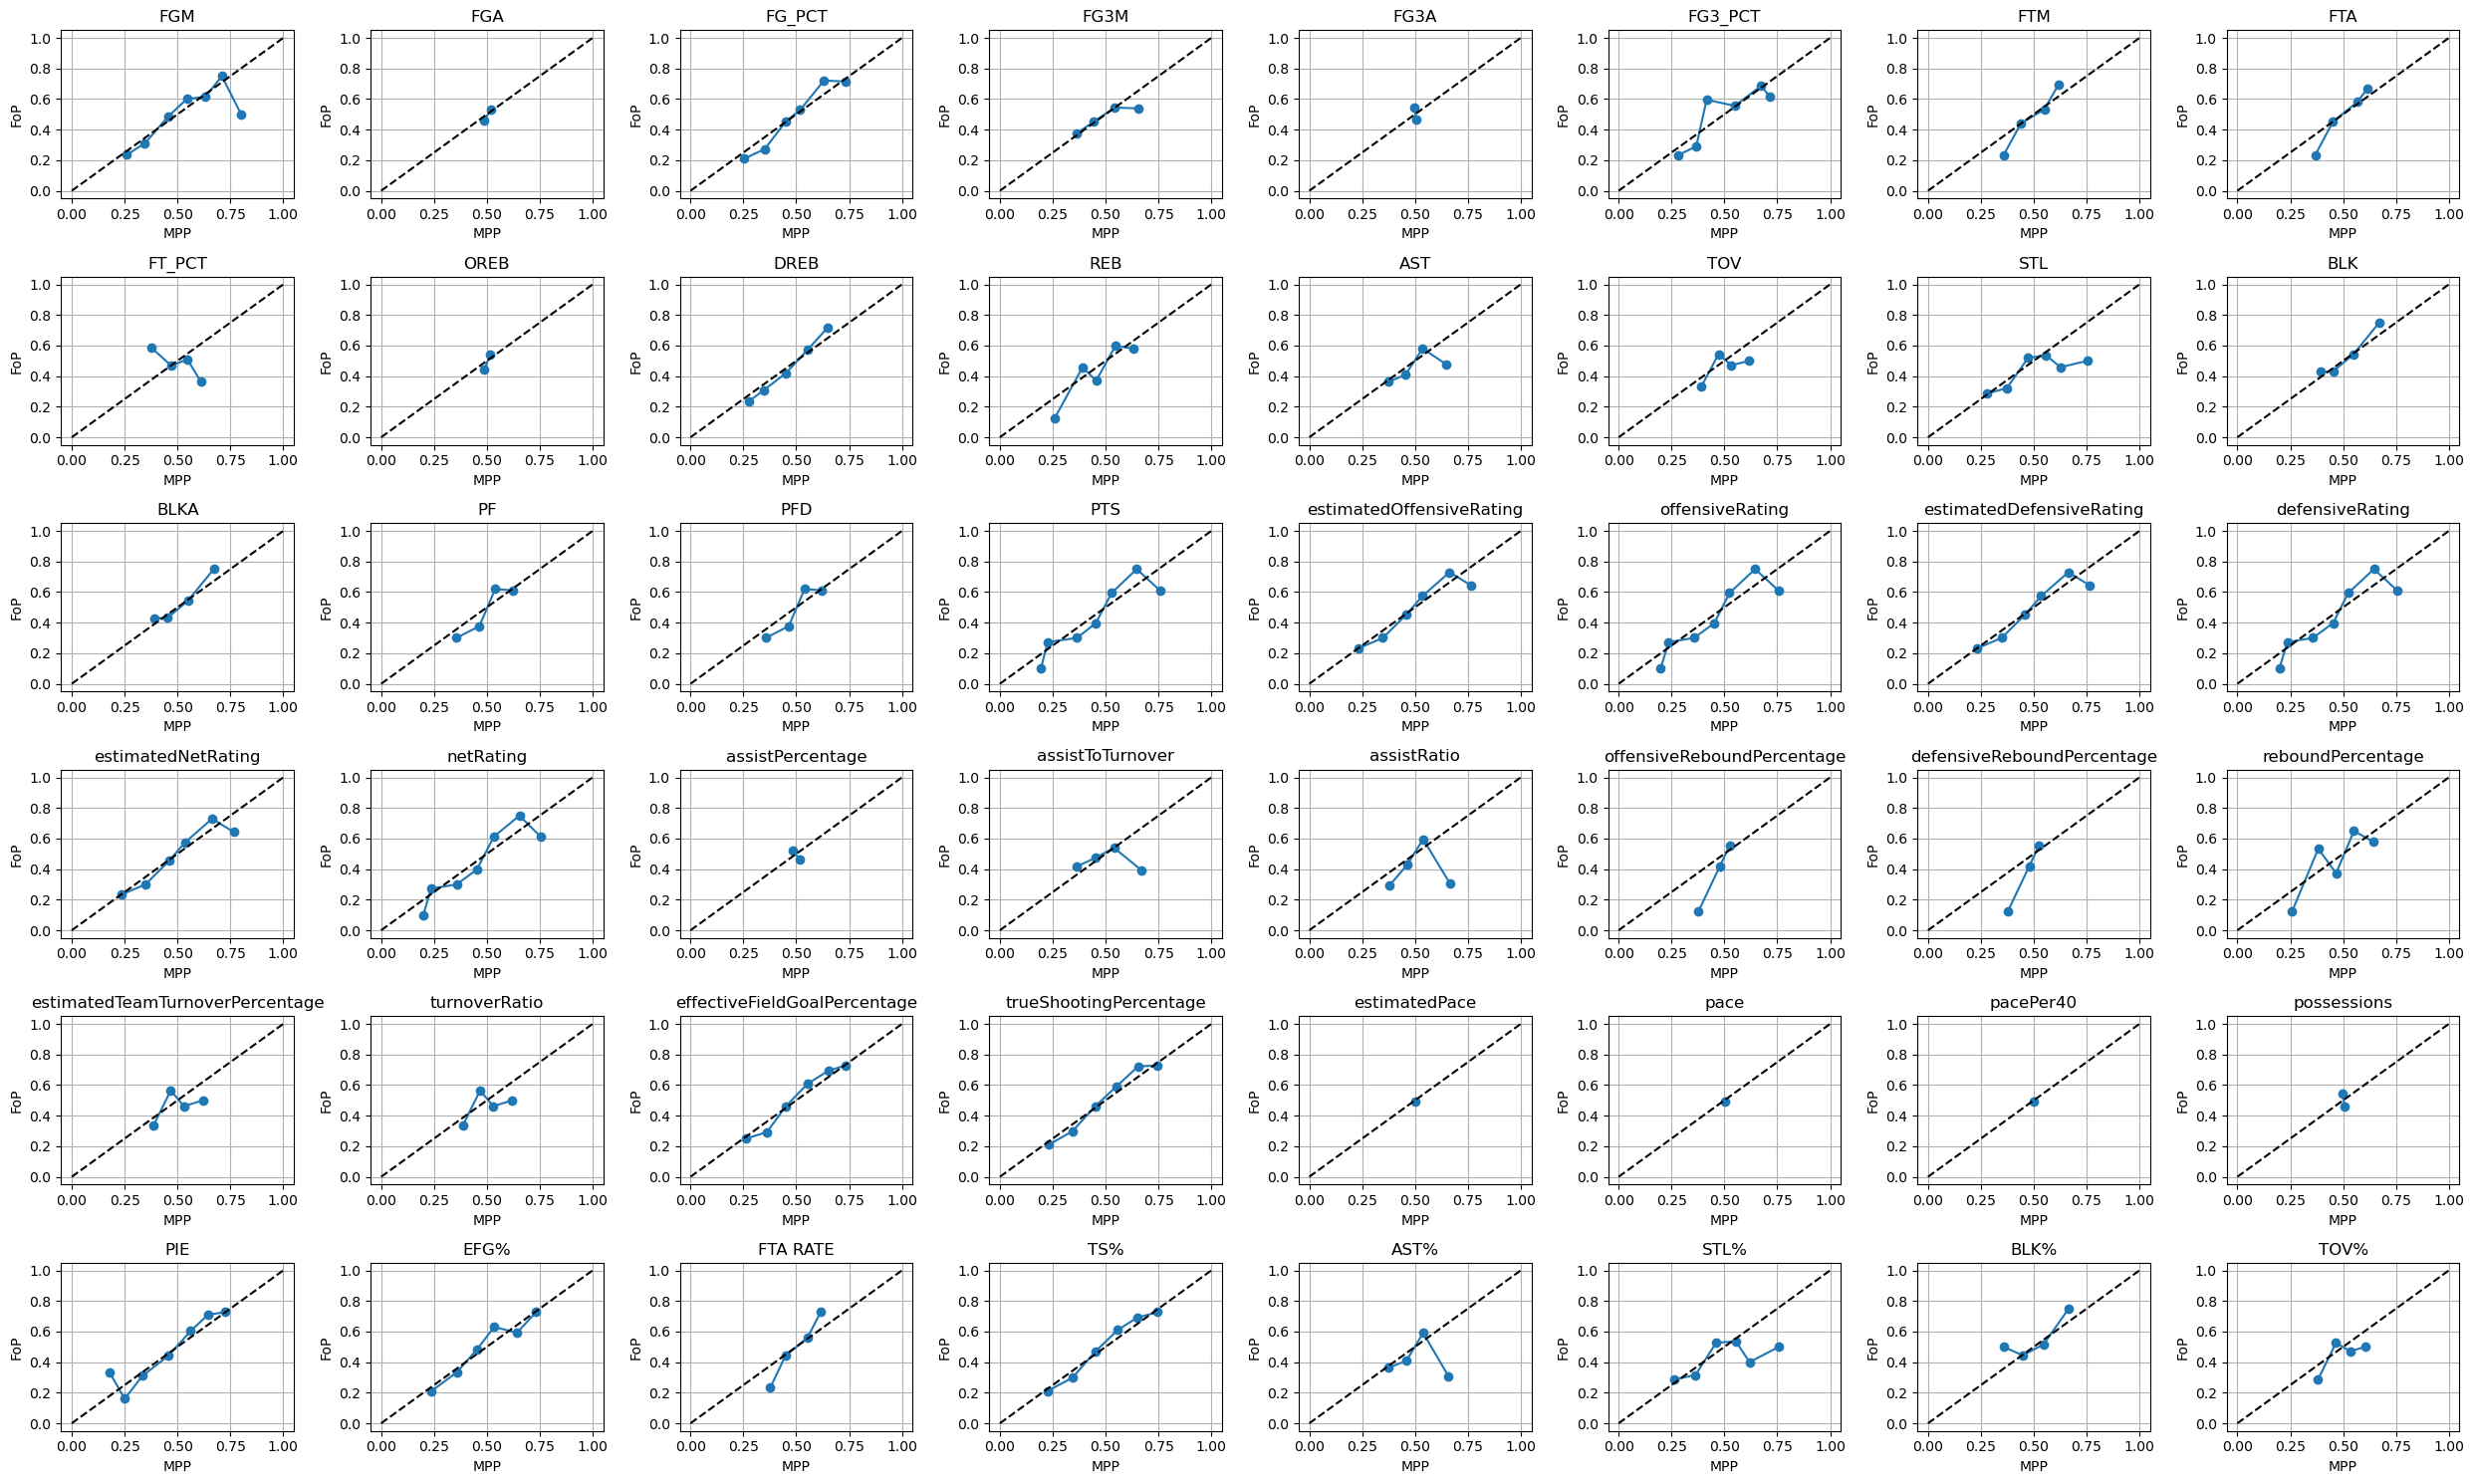

In [464]:


# Determine the number of rows and columns for the subplot grid
num_features = len([X.columns.get_loc(col) for col in X.columns])
num_cols = 8  # Adjust the number of columns as per your preference
num_rows = math.ceil(num_features / num_cols)

# Create subplots for each feature set
fig, axes = plt.subplots(num_rows, num_cols, figsize=(25, 15))  # Adjust figsize as needed

for idx, ax in zip([X.columns.get_loc(col) for col in X.columns], axes.flatten()):
    # Retrieve the calibrated probabilities and compute the calibration curve
    calibrated_probs = final_probs_df[X.columns[idx]]
    fraction_of_positives, mean_predicted_value = calibration_curve(y_val, calibrated_probs, n_bins=10)
    
    # Plot the calibration curve
    ax.plot(mean_predicted_value, fraction_of_positives, marker='o')
    
    # Plot the perfect calibration curve (diagonal dashed line)
    ax.plot([0, 1], [0, 1], linestyle='--', color='black')
    
    ax.set_xlabel('MPP')
    ax.set_ylabel('FoP')
    ax.set_title(f'{X.columns[idx]}')
    ax.grid(True)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


In [392]:
final_probs_df.head(5)

,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,...,pacePer40,possessions,PIE,EFG%,FTA RATE,TS%,AST%,STL%,BLK%,TOV%
0,0.403968,0.511668,0.449287,0.453176,0.502190,0.390427,0.565667,0.524894,0.610040,0.483229,...,0.502365,0.519305,0.473917,0.434857,0.522475,0.474010,0.492433,0.353222,0.475192,0.411260
1,0.392838,0.508023,0.415554,0.440492,0.496461,0.541696,0.615147,0.579804,0.577599,0.499996,...,0.502365,0.496373,0.488149,0.389296,0.578278,0.446349,0.469514,0.546333,0.357054,0.534131
2,0.800816,0.504212,0.770935,0.470798,0.494974,0.654210,0.468849,0.432363,0.593552,0.553047,...,0.502365,0.492390,0.729932,0.753180,0.442048,0.750575,0.511822,0.625880,0.571980,0.605631
3,0.429433,0.499869,0.426874,0.616479,0.510692,0.508828,0.512644,0.517939,0.484829,0.517798,...,0.502365,0.503863,0.453976,0.485717,0.512625,0.485385,0.440127,0.449874,0.521225,0.573792
4,0.618831,0.534026,0.703412,0.543020,0.500423,0.689085,0.552756,0.563808,0.479277,0.513693,...,0.502365,0.513846,0.718658,0.728032,0.582384,0.727279,0.562004,0.495002,0.589298,0.465352


In [442]:
y_val_df = pd.DataFrame(y_val)

final_probs_df.reset_index(drop=True, inplace=True)
y_val_df.reset_index(drop=True, inplace=True)

In [447]:
weighted_average = final_probs_df.apply(
    lambda row: sum(row[predictor] * inv_ece_weights[predictor] for predictor in final_probs_df.columns),
    axis=1
)

KeyError: 'weighted_average_pred'

In [444]:
final_probs_df['weighted_average_pred'] = weighted_average

In [445]:
final_probs_df = pd.concat([final_probs_df, y_val_df], axis=1)

In [446]:
final_probs_df['predicted_outcome'] = final_probs_df['weighted_average_pred'].apply(lambda x: 1 if x > 0.5 else 0)

correct_predictions = (final_probs_df['predicted_outcome'] == final_probs_df['WL']).sum()
total_predictions = len(final_probs_df)
accuracy = correct_predictions / total_predictions

print("Accuracy of weighted_avg_pred:", accuracy)

/var/folders/3z/8j8g_lgs5j7b31l1sp39n6380000gn/T/ipykernel_10405/4075100803.py:3: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  correct_predictions = (final_probs_df['predicted_outcome'] == final_probs_df['WL']).sum()


TypeError: '<' not supported between instances of 'str' and 'int'

In [409]:
drop(accuracy)

,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,...,EFG%,FTA RATE,TS%,AST%,STL%,BLK%,TOV%,weighted_average_pred,WL,predicted_outcome
0,0.403968,0.511668,0.449287,0.453176,0.502190,0.390427,0.565667,0.524894,0.610040,0.483229,...,0.434857,0.522475,0.474010,0.492433,0.353222,0.475192,0.411260,0.496302,0,0
1,0.392838,0.508023,0.415554,0.440492,0.496461,0.541696,0.615147,0.579804,0.577599,0.499996,...,0.389296,0.578278,0.446349,0.469514,0.546333,0.357054,0.534131,0.492879,0,0
2,0.800816,0.504212,0.770935,0.470798,0.494974,0.654210,0.468849,0.432363,0.593552,0.553047,...,0.753180,0.442048,0.750575,0.511822,0.625880,0.571980,0.605631,0.539869,0,1
3,0.429433,0.499869,0.426874,0.616479,0.510692,0.508828,0.512644,0.517939,0.484829,0.517798,...,0.485717,0.512625,0.485385,0.440127,0.449874,0.521225,0.573792,0.501852,0,1
4,0.618831,0.534026,0.703412,0.543020,0.500423,0.689085,0.552756,0.563808,0.479277,0.513693,...,0.728032,0.582384,0.727279,0.562004,0.495002,0.589298,0.465352,0.539068,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260,0.304597,0.508159,0.349347,0.426011,0.503828,0.270154,0.425528,0.422672,0.502324,0.516426,...,0.323950,0.439912,0.311591,0.539827,0.409175,0.594497,0.463232,0.473939,1,0
261,0.501459,0.536911,0.615746,0.435157,0.496512,0.508564,0.619864,0.587568,0.571705,0.510935,...,0.596859,0.603457,0.650827,0.523285,0.428854,0.566157,0.444564,0.523641,1,1
262,0.496626,0.543774,0.629028,0.620252,0.506754,0.676553,0.578531,0.606618,0.445162,0.518346,...,0.691844,0.618703,0.691655,0.491803,0.495867,0.571499,0.445251,0.532406,1,1
263,0.614362,0.478122,0.513120,0.687276,0.515715,0.536434,0.346087,0.351581,0.494426,0.511814,...,0.600081,0.355157,0.547253,0.658404,0.615516,0.535949,0.527155,0.506095,0,1


# Extracting raw betting data using SBRScrape

In [76]:
# Initialize dataframes
df = pd.DataFrame()
bets_df = pd.DataFrame()

In [290]:
# Testing endpoint
# Scoreboard(sport="NBA", date='2023-11-08').games


In [78]:
import pandas as pd
from datetime import datetime, timedelta
from sbrscrape import Scoreboard  # Assuming Scoreboard is imported from the sbrscrape package

# Set the start date to October 1, 2023
start_date = datetime(2023, 10, 25)

# Create an empty list to store DataFrames for each date
dfs = []

# Initialize the current date to the start date
current_date = start_date

# Set the end date to December 31, 2023
end_date = datetime(2023, 11, 10)

# Fetch data for each date until the end date is reached
while current_date <= end_date:
    try:
        # the date parameter operates weirdly, seems to get the day after the input date?
        games = Scoreboard(sport="NBA", date=current_date).games
        u_df = pd.DataFrame(games)
        dfs.append(u_df)
        print(f"Data fetched for {current_date}")
    except Exception as e:
        print(f"Error fetching data for {current_date}: {e}")

    current_date += timedelta(days=1)

# Concatenate intermediate df into the final bets_df
if dfs:
    df = pd.concat(dfs, ignore_index=True)
    bets_df = pd.DataFrame(df)
    print("Concatenation successful.")
else:
    print("No data fetched. Check for errors during data retrieval.")


Data fetched for 2023-10-25 00:00:00
Data fetched for 2023-10-26 00:00:00
Data fetched for 2023-10-27 00:00:00
Data fetched for 2023-10-28 00:00:00
Data fetched for 2023-10-29 00:00:00
Data fetched for 2023-10-30 00:00:00
Data fetched for 2023-10-31 00:00:00
Data fetched for 2023-11-01 00:00:00
Data fetched for 2023-11-02 00:00:00
Data fetched for 2023-11-03 00:00:00
Data fetched for 2023-11-04 00:00:00
Data fetched for 2023-11-05 00:00:00
Data fetched for 2023-11-06 00:00:00
Error fetching data for 2023-11-07 00:00:00: 'Scoreboard' object has no attribute 'games'
Data fetched for 2023-11-08 00:00:00
Data fetched for 2023-11-09 00:00:00
Data fetched for 2023-11-10 00:00:00
Concatenation successful.


In [80]:
home_spread_odds_df = bets_df['home_spread_odds'].apply(pd.Series).add_suffix('_home_spread_odds')
away_spread_odds_df = bets_df['away_spread_odds'].apply(pd.Series).add_suffix('_away_spread_odds')
under_odds_df = bets_df['under_odds'].apply(pd.Series).add_suffix('_under_odds')
over_odds_df = bets_df['over_odds'].apply(pd.Series).add_suffix('_over_odds')
home_ml_df = bets_df['home_ml'].apply(pd.Series).add_suffix('_home_ml')
away_ml_df = bets_df['away_ml'].apply(pd.Series).add_suffix('_away_ml')

df_games = pd.concat([bets_df, home_ml_df, away_ml_df], axis=1)

columns_to_drop = ['home_spread', 'home_spread_odds', 'away_spread', 'away_spread_odds', 'under_odds', 'over_odds', 'total', 'home_ml', 'away_ml']
bets_df = bets_df.drop(columns_to_drop, axis=1)

In [81]:
moneyline_columns = [
    'betvictor_away_ml', 'tonybet_away_ml', 'bet365_away_ml', 'pinnacle_away_ml', 
    'sportsinteraction_away_ml', '888sport_away_ml', 'comeon_away_ml', 'caesars_away_ml', 
    'betmgm_away_ml', 'bet_rivers_ny_away_ml', 'pointsbet_away_ml', 'betway_away_ml', 
    'fanduel_away_ml', 'draftkings_away_ml',
    'betvictor_home_ml', 'tonybet_home_ml', 'bet365_home_ml', 'pinnacle_home_ml', 
    'sportsinteraction_home_ml', '888sport_home_ml', 'comeon_home_ml', 'caesars_home_ml', 
    'betmgm_home_ml', 'bet_rivers_ny_home_ml', 'pointsbet_home_ml', 'betway_home_ml', 
    'fanduel_home_ml', 'draftkings_home_ml'
]

for column in moneyline_columns:
    odds = []

    for odd in df_games[column]:
        if odd < 0:
            ip = (-1 * odd) / ((-1 * odd) + 100)
        else:
            ip = 100 / (odd + 100)
        
        odds.append(ip)

    bets_df[column + '_iprob'] = odds

In [82]:
columns_to_drop = ['home_team_loc', 'away_team_loc', 'home_team_abbr', 'away_team_abbr', 'home_team_rank', 'away_team_rank']
# df_games.drop(columns=moneyline_columns, inplace=True)
bets_df.drop(columns=columns_to_drop, inplace=True)

In [83]:
bets_df

,date,status,home_team,away_team,home_score,away_score,betvictor_away_ml_iprob,tonybet_away_ml_iprob,bet365_away_ml_iprob,pinnacle_away_ml_iprob,...,sportsinteraction_home_ml_iprob,888sport_home_ml_iprob,comeon_home_ml_iprob,caesars_home_ml_iprob,betmgm_home_ml_iprob,bet_rivers_ny_home_ml_iprob,pointsbet_home_ml_iprob,betway_home_ml_iprob,fanduel_home_ml_iprob,draftkings_home_ml_iprob
0,2023-10-25T23:00:00+00:00,Final,Indiana Pacers,Washington Wizards,143,120,0.392157,0.395257,0.370370,0.377358,...,0.666667,0.666667,0.671053,0.763593,0.666667,0.661017,0.655172,0.655172,0.672131,0.666667
1,2023-10-25T23:00:00+00:00,Final,Charlotte Hornets,Atlanta Hawks,116,110,0.625468,0.641577,0.629630,0.635036,...,0.400000,0.425532,0.392157,0.442478,0.400000,0.411523,0.408163,0.416667,0.396825,0.378788
2,2023-10-25T23:00:00+00:00,Final,Orlando Magic,Houston Rockets,116,86,0.408163,0.406504,0.377358,0.389105,...,0.649123,0.652778,0.632353,0.616858,0.649123,0.638989,0.655172,0.636364,0.647887,0.677419
3,2023-10-25T23:00:00+00:00,Final,New York Knicks,Boston Celtics,104,108,0.625468,0.636364,0.629630,0.624060,...,0.408163,0.416667,0.408163,0.458716,0.408163,0.411523,0.408163,0.425532,0.406504,0.434783
4,2023-10-25T23:30:00+00:00,Final,Miami Heat,Detroit Pistons,103,102,0.232558,0.230415,0.222222,0.224719,...,0.818182,0.833333,0.847561,0.806576,0.818182,0.827586,0.809524,0.818182,0.818182,0.826087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,2023-11-11T01:00:00+00:00,Final,Houston Rockets,New Orleans Pelicans,104,101,0.434783,0.429185,0.434783,0.432900,...,0.600000,0.619772,0.613900,0.616858,0.600000,0.585062,0.600000,0.600000,0.606299,0.596774
122,2023-11-11T01:00:00+00:00,Final,Memphis Grizzlies,Utah Jazz,121,127,0.377358,0.384615,0.370370,0.381679,...,0.655172,0.666667,0.692308,0.671053,0.655172,0.666667,0.655172,0.655172,0.655172,0.642857
123,2023-11-11T01:30:00+00:00,Final,Dallas Mavericks,Los Angeles Clippers,144,126,0.500000,0.509804,0.487805,0.495050,...,0.545455,0.408163,0.555556,0.523810,0.555556,0.444444,0.534884,0.534884,0.541284,0.541284
124,2023-11-11T03:00:00+00:00,Final,Sacramento Kings,Oklahoma City Thunder,105,98,0.541284,0.559471,0.555556,0.543379,...,0.500000,0.545455,0.487805,0.476190,0.500000,0.565217,0.565217,0.512195,0.500000,0.583333
